In [37]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

# Set global styles and settings
plt.style.use('ggplot')
pd.set_option('display.max_columns', 50)

In [38]:
def detect_outliers(df, columns, method='iqr'):
    outliers_report = {}
    for col in columns:
        # ایجاد یک کپی از ستون برای محاسبات
        col_data = df[col].copy()
        
        if method == 'iqr':
            Q1 = col_data.quantile(0.25)
            Q3 = col_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers_mask = (col_data < lower_bound) | (col_data > upper_bound)
            
        elif method == 'zscore':
            # محاسبه z-score فقط برای مقادیر غیر NaN
            valid_mask = col_data.notna()
            z_scores = np.zeros(len(col_data))
            z_scores[valid_mask] = stats.zscore(col_data[valid_mask])
            outliers_mask = np.abs(z_scores) > 3
        
        # شناسایی outlierها با حفظ ساختار اصلی
        outliers = df[outliers_mask]
        
        outliers_report[col] = {
            'count': outliers_mask.sum(),
            'percentage': (outliers_mask.mean()) * 100,
            'min_outlier': outliers[col].min() if not outliers.empty else None,
            'max_outlier': outliers[col].max() if not outliers.empty else None
        }
        
        # رسم نمودار
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=col_data)
        plt.title(f'Boxplot for {col} (Method: {method})')
        plt.show()
    
    return pd.DataFrame(outliers_report).T

In [39]:
def generate_recommendations(df, output_dir):
    """تولید توصیه‌های مبتنی بر تحلیل داده‌ها"""
    recs = []
    
    # تحلیل مقادیر گمشده (با جایگزینی ایموجی‌ها)
    missing_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
    if missing_cols:
        recs.append("[WARNING] ستون‌های دارای مقادیر گمشده: " + ", ".join(missing_cols))
        recs.append("[SUGGESTION] پیشنهاد: پر کردن مقادیر گمشده با میانه (برای داده‌های عددی) یا مد (برای داده‌های دسته‌ای)")
    
    # تحلیل outlierها (با جایگزینی ایموجی‌ها)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].skew() > 3:
            recs.append(f"[ALERT] ستون {col} دارای توزیع بسیار اریب است (Skewness: {df[col].skew():.2f})")
            recs.append(f"[SUGGESTION] پیشنهاد: اعتباریابی مجدد داده‌ها یا استفاده از تبدیل‌های لگاریتمی")
    
    # ذخیره با کدگذاری UTF-8 و مدیریت خطا
    try:
        with open(f"{output_dir}/recommendations.txt", "w", encoding='utf-8') as f:
            f.write("\n".join(recs))
    except Exception as e:
        print(f"خطا در ذخیره فایل: {str(e)}")
        # ذخیره جایگزین بدون کاراکترهای خاص
        with open(f"{output_dir}/recommendations.txt", "w") as f:
            f.write("\n".join(recs).encode('ascii', 'ignore').decode('ascii'))
    
    return recs

In [40]:
def comprehensive_eda(file_path, output_dir="eda_results"):
    """تحلیل اکتشافی جامع برای داده‌های حفاری"""
    # 1. تنظیمات اولیه
    from pathlib import Path
    output_dir = "output"
    Path(output_dir).mkdir(exist_ok=True)
    Path(f"{output_dir}/plots").mkdir(exist_ok=True)
    
    # 2. بارگذاری داده‌ها
    print(" در حال بارگذاری داده‌ها...")
    df = pd.read_parquet(file_path)
    print(f" داده با {len(df)} رکورد و {len(df.columns)} ویژگی بارگذاری شد.")
    
    # 3. تحلیل ساختار داده‌ها
    print("\n تحلیل ساختار داده‌ها:")
    print("🔹 اطلاعات کلی:")
    print(df.info())
    
    # 4. تحلیل آماری
    stats_report = df.describe(include='all').T
    stats_report['missing_%'] = (df.isnull().sum() / len(df)) * 100
    stats_report.to_csv(f"{output_dir}/statistical_report.csv")
    display(stats_report)
    
    # 5. تحلیل مقادیر گمشده
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Analysis')
    plt.show()
    
    # 6. تحلیل توزیع ویژگی‌های عددی
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols[:5]:  # فقط 5 ستون اول برای نمایش
        try:
            plt.figure(figsize=(12, 6))
            sns.histplot(df[col], kde=True, bins=50)
            plt.title(f'Distribution of {col}')
            plt.show()
        except:
            continue
    
    # 7. شناسایی outlierها
    outliers_iqr = detect_outliers(df, numeric_cols[:5], 'iqr')  # فقط 5 ستون اول برای نمایش
    outliers_zscore = detect_outliers(df, numeric_cols[:5], 'zscore')
    display(outliers_iqr)
    
    # 8. تحلیل همبستگی
    plt.figure(figsize=(12, 10))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.show()
    
    # 9. تحلیل ویژگی‌های دسته‌ای
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols[:3]:  # فقط 3 ستون اول برای نمایش
        plt.figure(figsize=(12, 6))
        df[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.show()
    
    # 10. تحلیل هدف‌محور
    if 'Formation_Damage_Index' in df.columns:
        # تحلیل رابطه با ویژگی‌های عددی
        top_corr = corr['Formation_Damage_Index'].sort_values(ascending=False)
        display(top_corr.head(10))
        
        # تحلیل توزیع
        plt.figure(figsize=(12, 6))
        sns.histplot(df['Formation_Damage_Index'], kde=True, bins=50)
        plt.title('Distribution of Formation_Damage_Index')
        plt.show()
    
    # 11. تولید گزارش HTML
    print("\n در حال تولید گزارش جامع...")
    profile = ProfileReport(df, title="Drilling Data EDA Report", explorative=True)
    profile.to_file(f"{output_dir}/drilling_eda_report.html")
    
    # 12. خلاصه‌یافته‌ها و توصیه‌ها
    recommendations = generate_recommendations(df, output_dir)
    
    print(f"\n تحلیل اکتشافی با موفقیت انجام شد! نتایج در پوشه '{output_dir}' ذخیره شد.")
    return df.head(), recommendations

 در حال بارگذاری داده‌ها...
 داده با 1000000 رکورد و 33 ویژگی بارگذاری شد.

 تحلیل ساختار داده‌ها:
🔹 اطلاعات کلی:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 33 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Depth_m                     970000 non-null   float64       
 1   ROP_mph                     970000 non-null   float64       
 2   WOB_kgf                     970000 non-null   float64       
 3   Torque_Nm                   970000 non-null   float64       
 4   Pump_Pressure_psi           970000 non-null   float64       
 5   Mud_FlowRate_LPM            970000 non-null   float64       
 6   MWD_Vibration_g             970000 non-null   float64       
 7   Bit_Type                    1000000 non-null  object        
 8   Mud_Weight_ppg              970000 non-null   float64       
 9   Viscosity_cP                970000 non-null

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,missing_%
Depth_m,970000.0,NaN,NaN,NaN,3001.653598,854.274884,2460.393967,2999.100119,3540.051071,6088.369612,795.984558,3.0
ROP_mph,970000.0,NaN,NaN,NaN,20.095347,3.530648,14.605877,20.004573,25.401042,50.973825,7.793348,3.0
WOB_kgf,970000.0,NaN,NaN,NaN,15034.440994,3965.837334,11622.165469,14992.565731,18359.899298,30874.753635,4895.358486,3.0
Torque_Nm,970000.0,NaN,NaN,NaN,1003.194104,124.052354,730.409756,1000.414534,1270.861611,2074.27916,390.204428,3.0
Pump_Pressure_psi,970000.0,NaN,NaN,NaN,2485.625581,762.887778,2214.402807,2482.371999,2752.908865,4327.469986,395.76244,3.0
Mud_FlowRate_LPM,970000.0,NaN,NaN,NaN,310.121103,-260.289466,224.097996,309.99693,395.97014,923.997065,127.657292,3.0
MWD_Vibration_g,970000.0,NaN,NaN,NaN,1.549552,-0.052201,0.825491,1.548478,2.273643,3.162322,0.838012,3.0
Bit_Type,1000000,3,Diamond,333653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Mud_Weight_ppg,970000.0,NaN,NaN,NaN,11.029245,8.201962,9.990772,11.001254,12.012382,15.235799,1.433191,3.0
Viscosity_cP,970000.0,NaN,NaN,NaN,70.15657,26.188101,56.513647,70.044937,83.506426,124.353081,19.513431,3.0


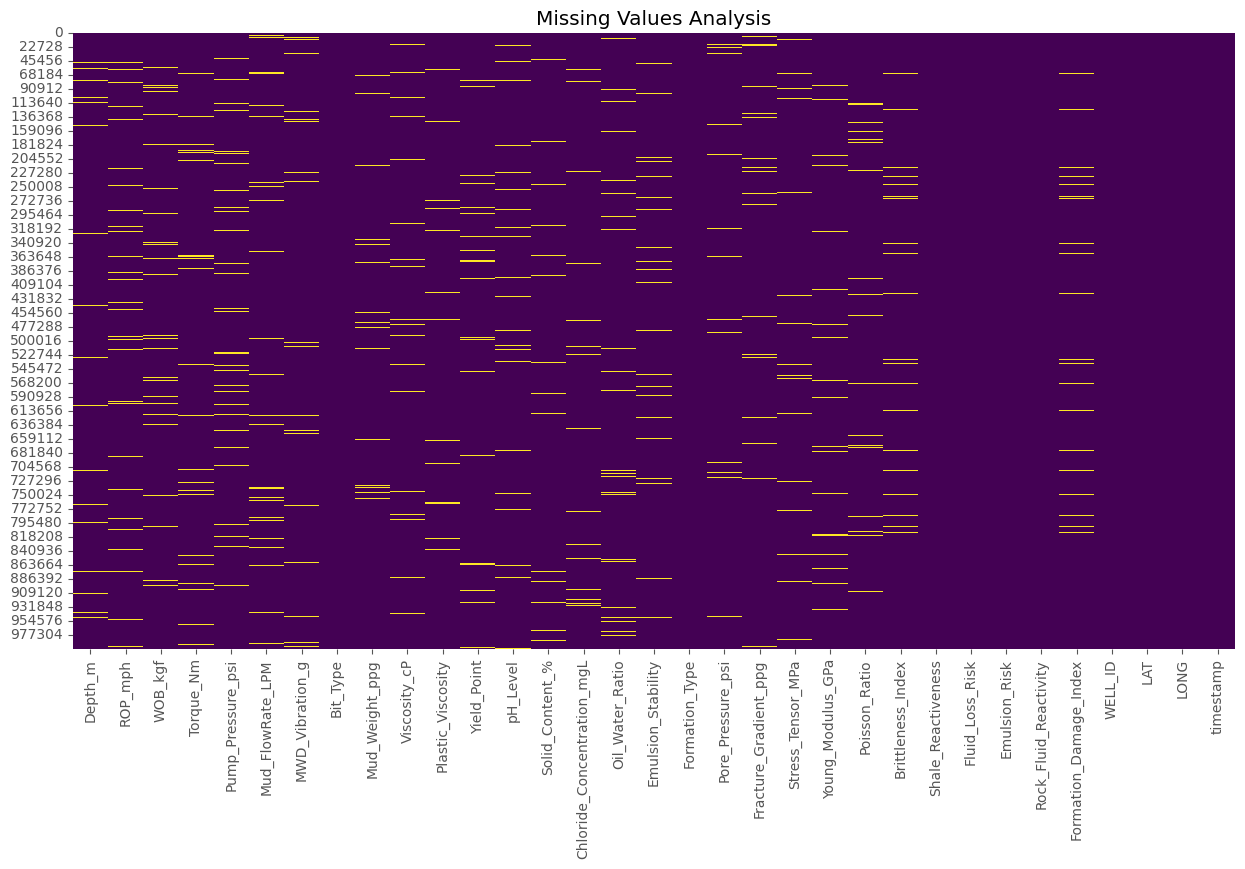

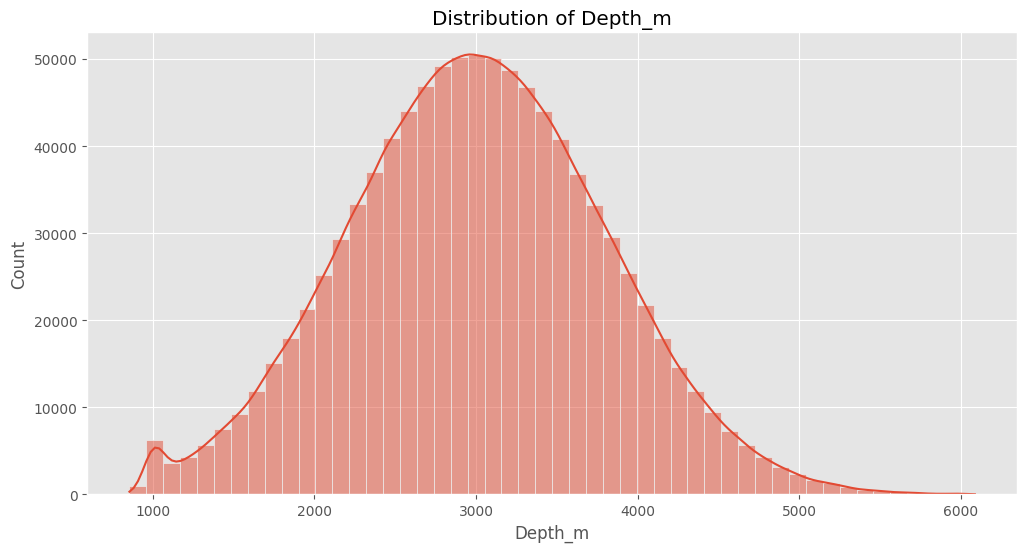

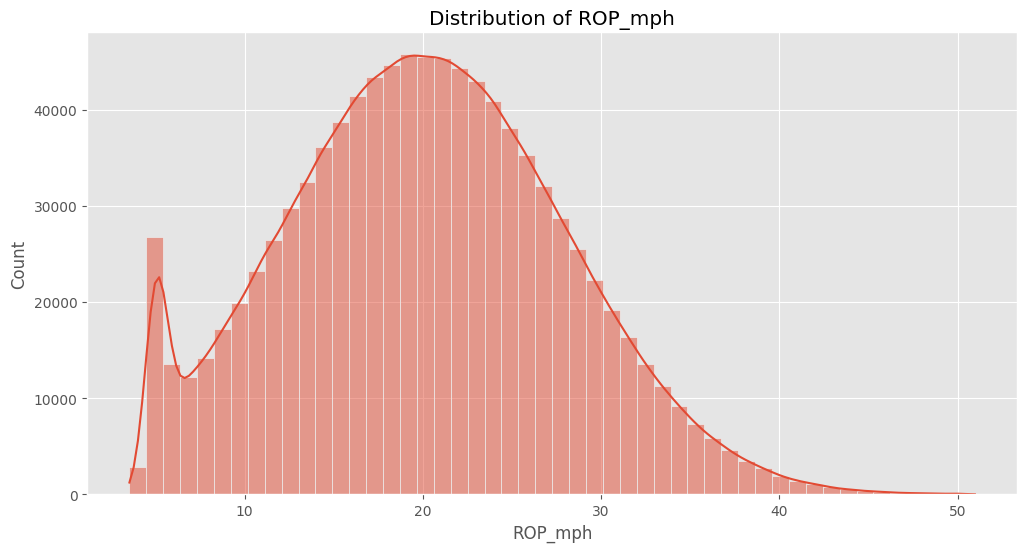

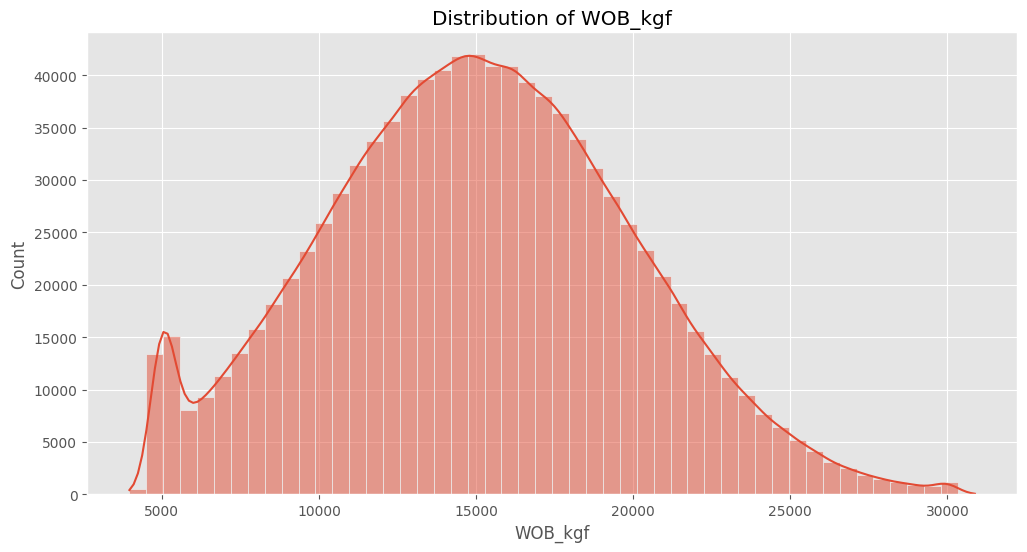

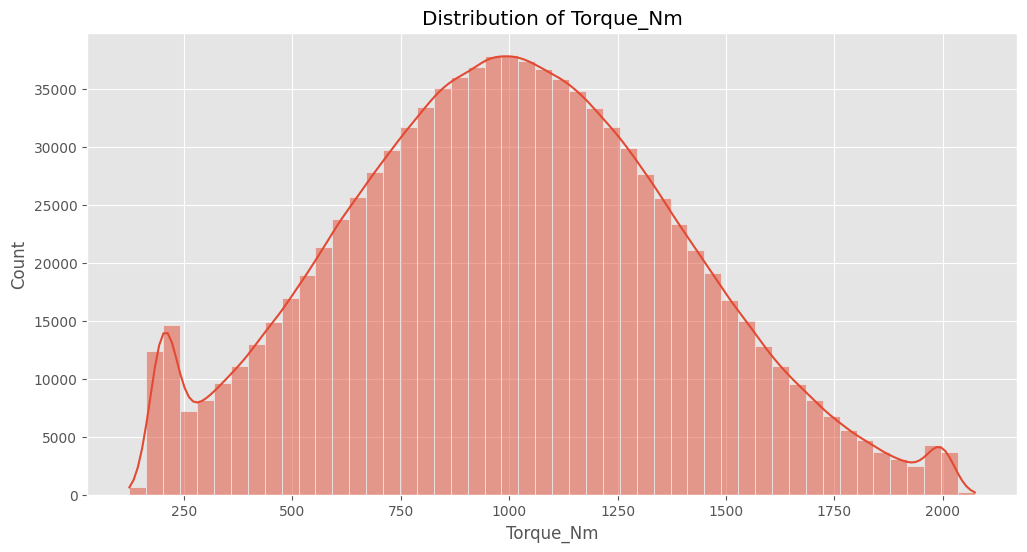

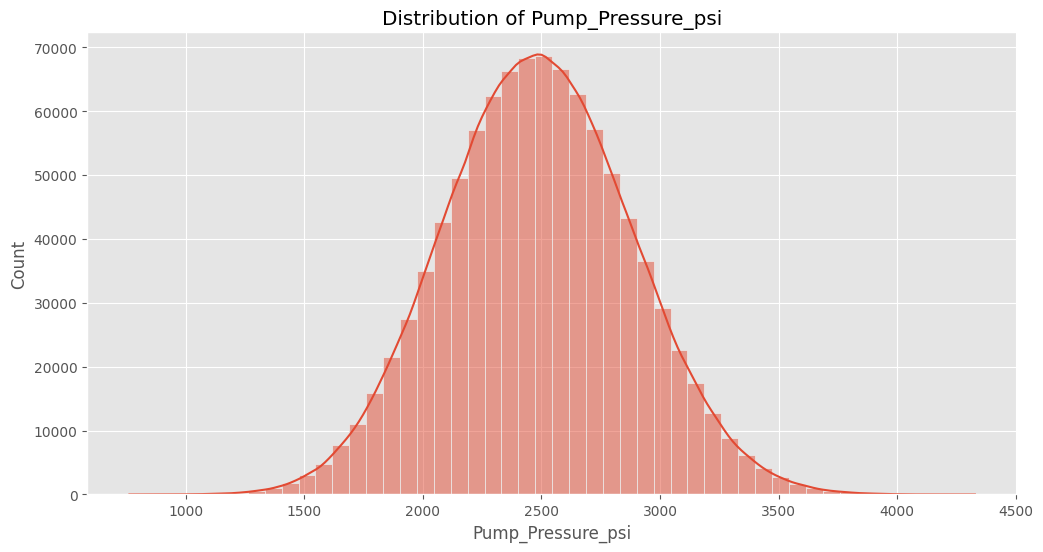

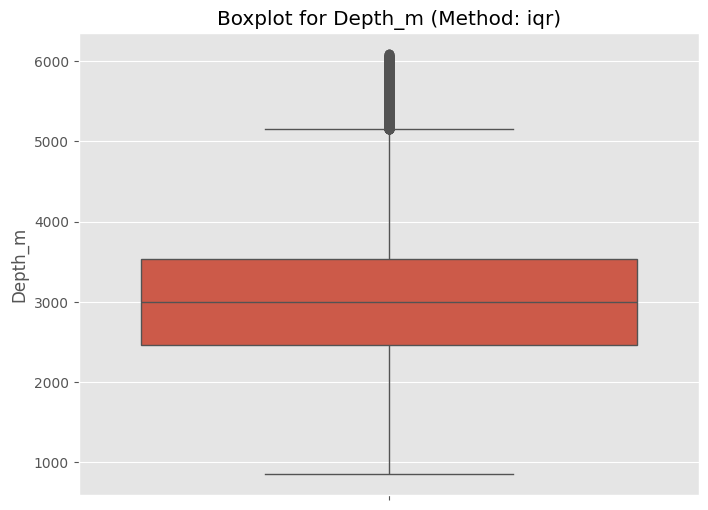

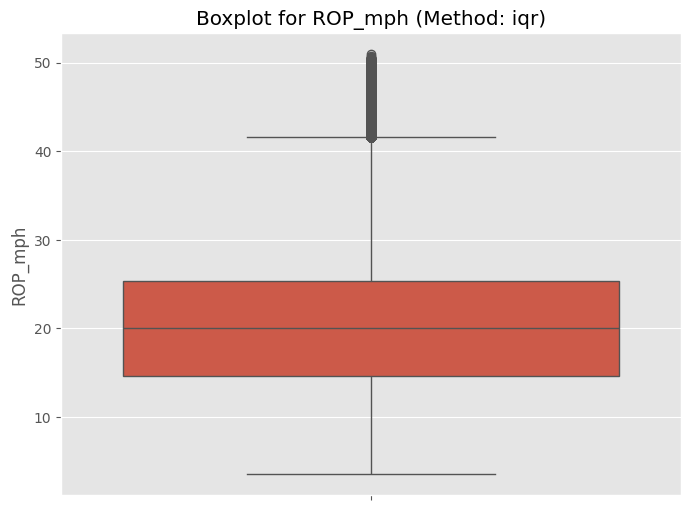

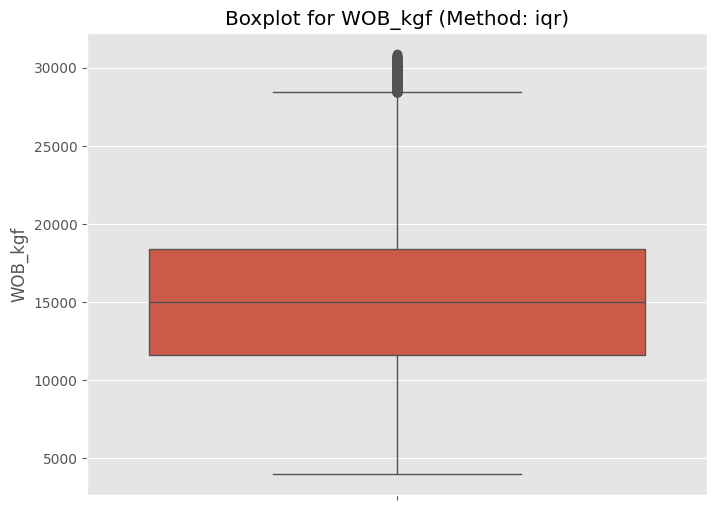

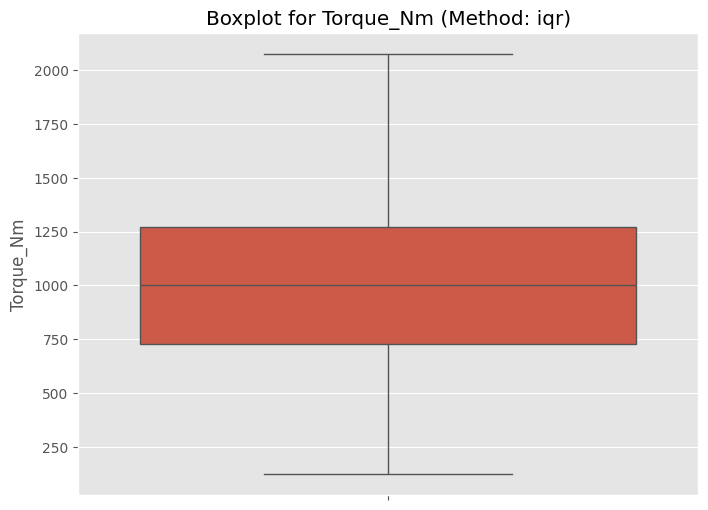

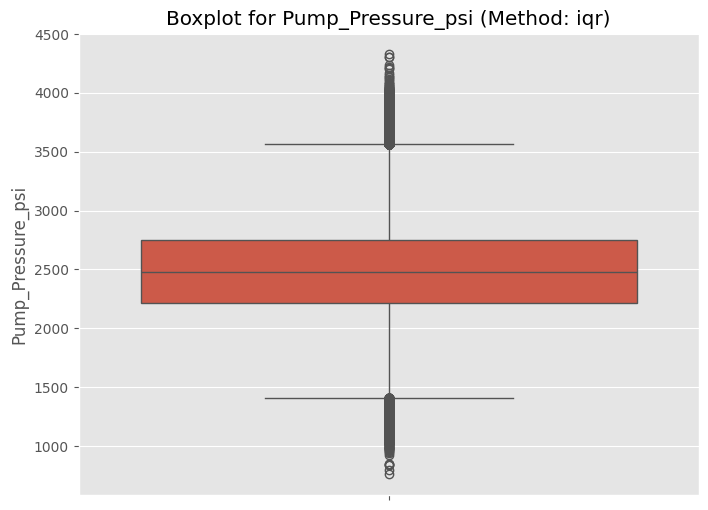

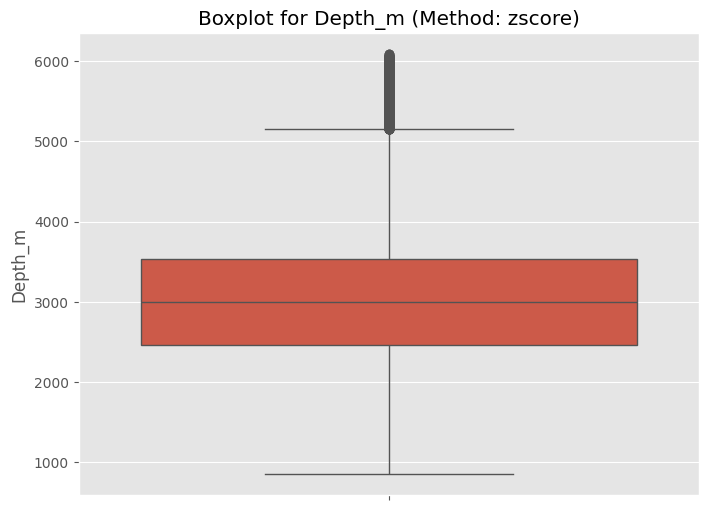

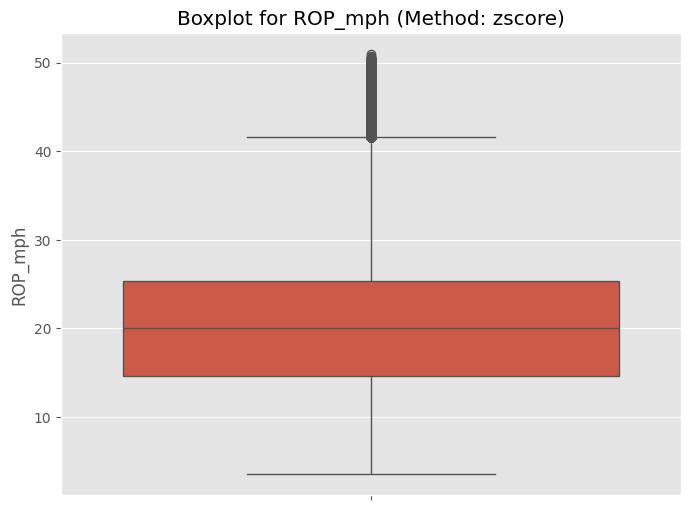

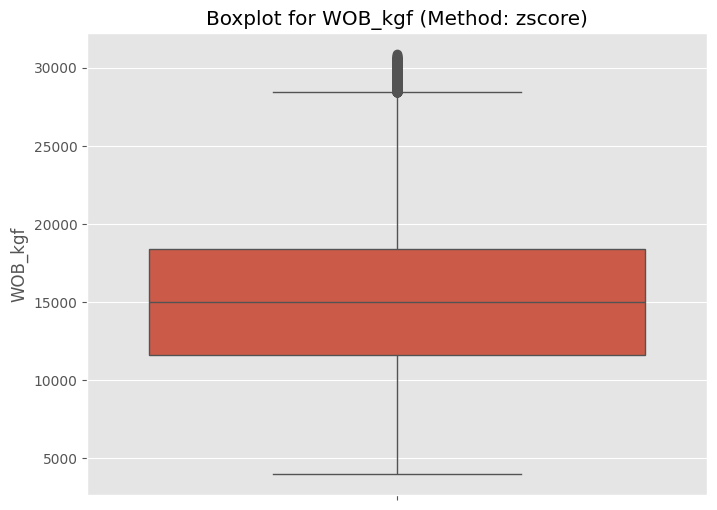

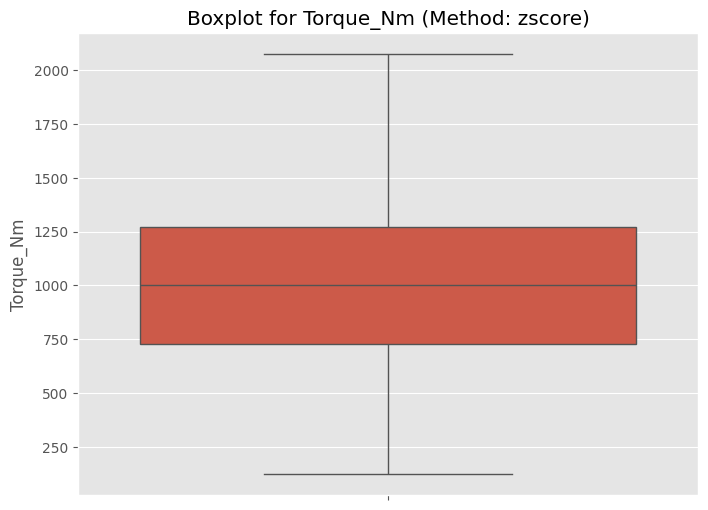

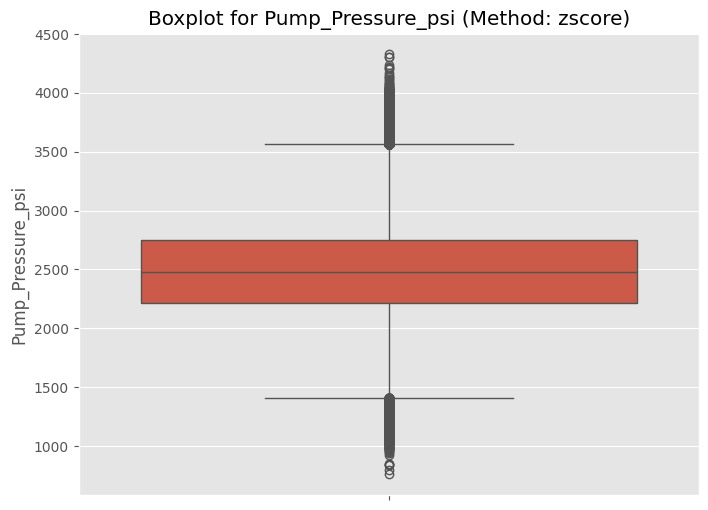

,count,percentage,min_outlier,max_outlier
Depth_m,3487.0,0.3487,5159.851089,6088.369612
ROP_mph,3390.0,0.3390,41.594901,50.973825
WOB_kgf,3497.0,0.3497,28467.022983,30874.753635
Torque_Nm,0.0,0.0000,NaN,NaN
Pump_Pressure_psi,5595.0,0.5595,762.887778,4327.469986


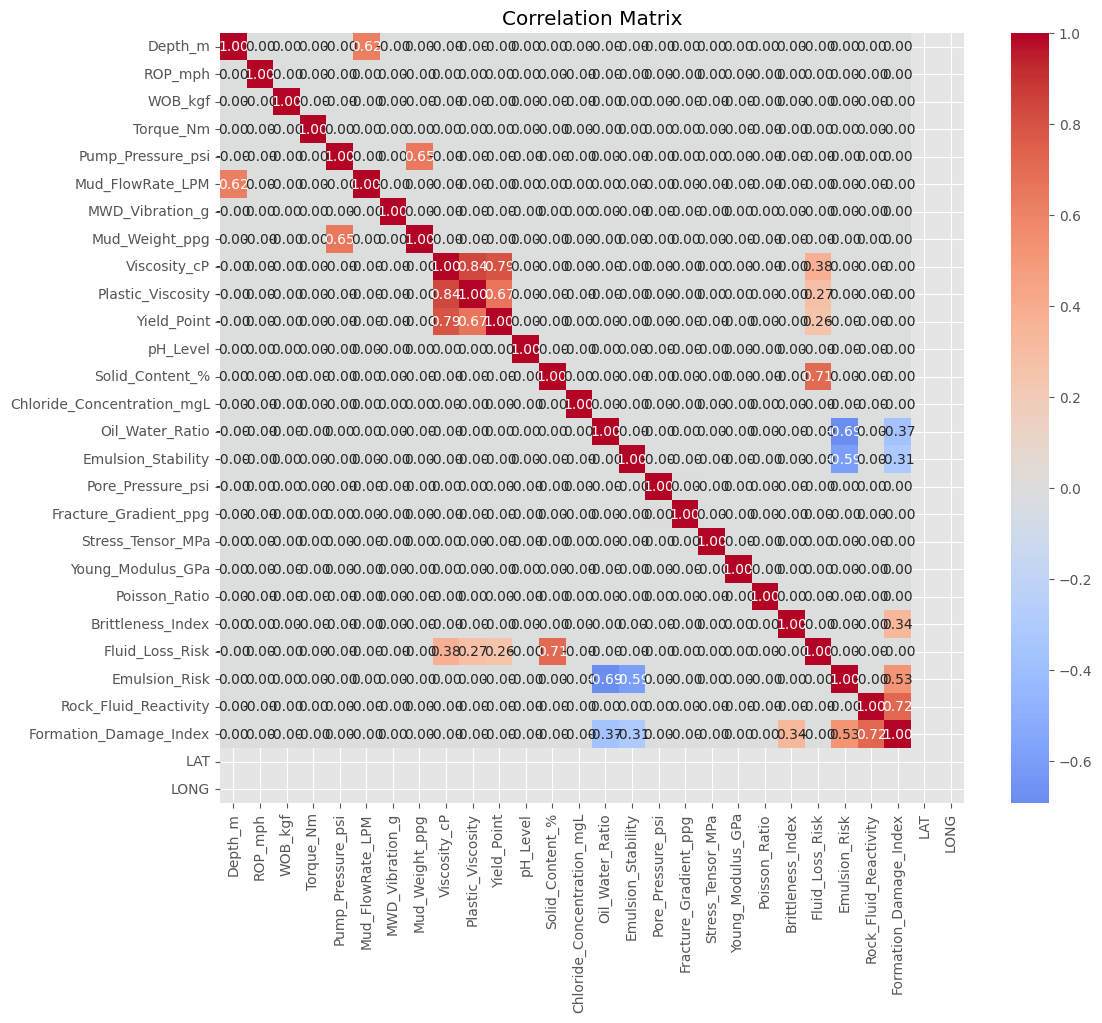

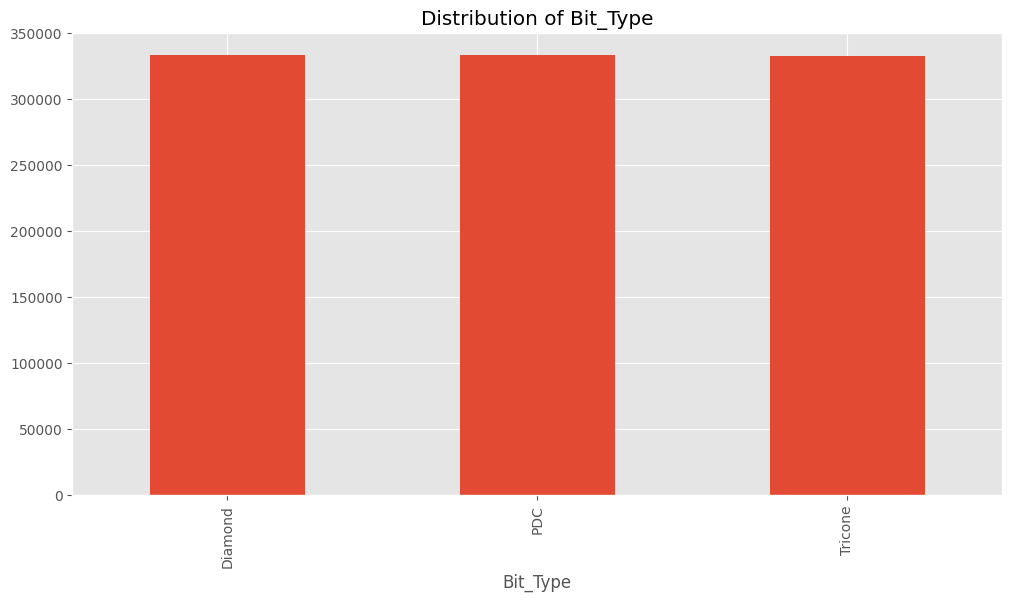

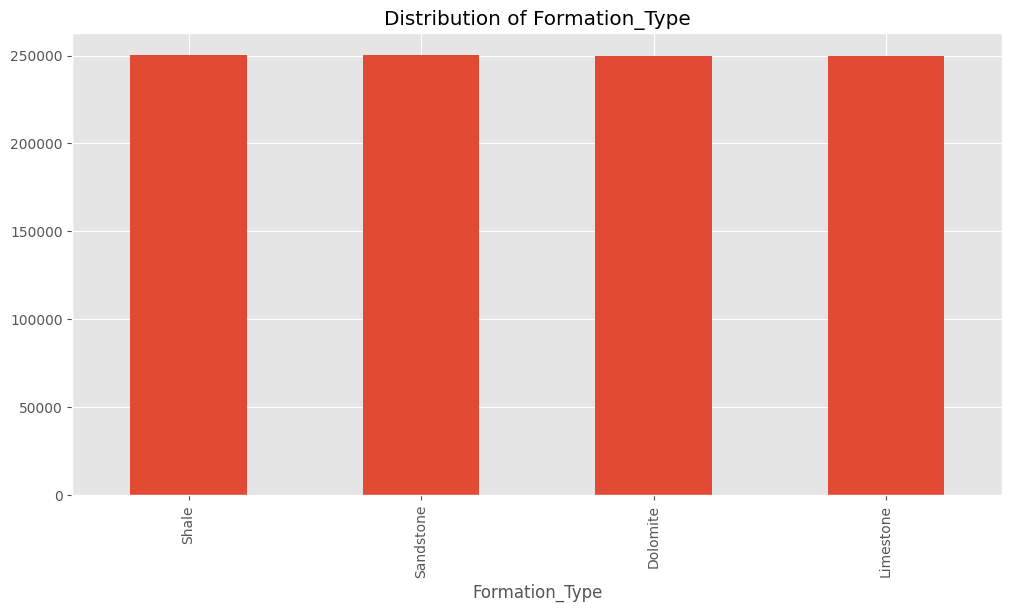

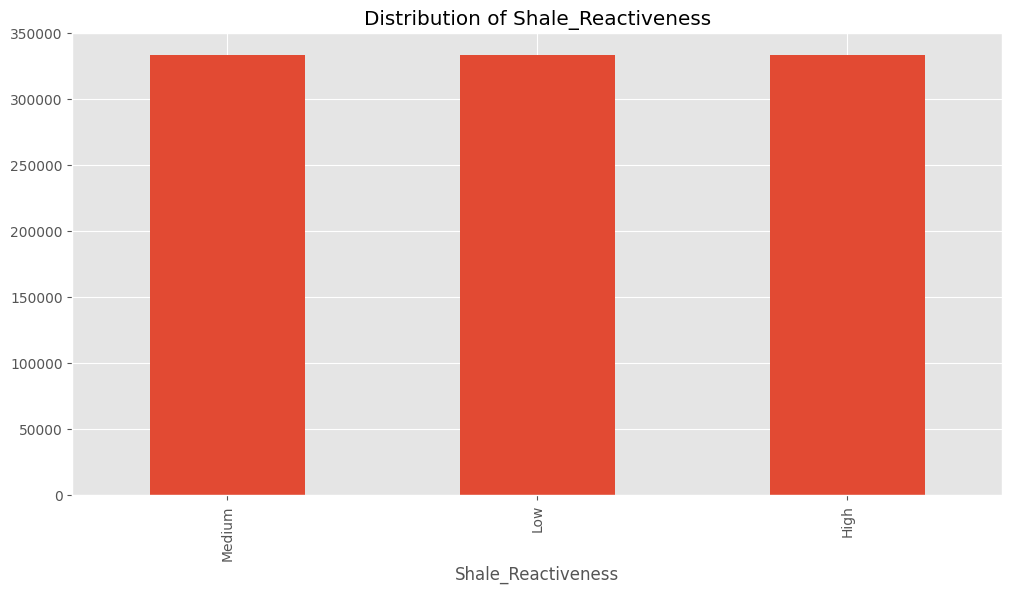

Formation_Damage_Index    1.000000
Rock_Fluid_Reactivity     0.718811
Emulsion_Risk             0.530172
Brittleness_Index         0.339935
Pore_Pressure_psi         0.001197
Depth_m                   0.000954
Young_Modulus_GPa         0.000844
ROP_mph                   0.000754
Pump_Pressure_psi         0.000401
MWD_Vibration_g           0.000209
Name: Formation_Damage_Index, dtype: float64

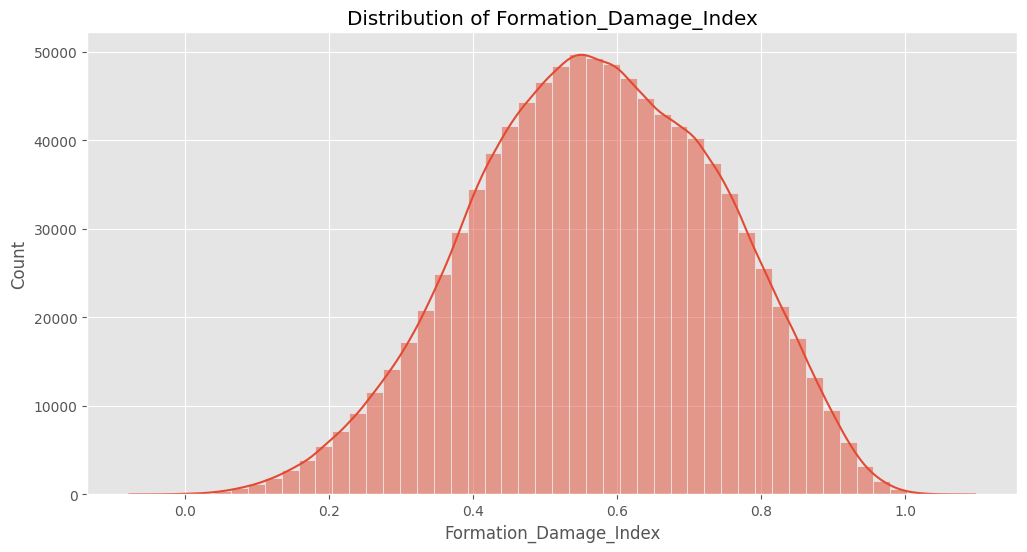


 در حال تولید گزارش جامع...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:43<00:00,  1.32s/it]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


 تحلیل اکتشافی با موفقیت انجام شد! نتایج در پوشه 'output' ذخیره شد.

نمونه‌ای از داده‌ها:


,Depth_m,ROP_mph,WOB_kgf,Torque_Nm,Pump_Pressure_psi,Mud_FlowRate_LPM,MWD_Vibration_g,Bit_Type,Mud_Weight_ppg,Viscosity_cP,Plastic_Viscosity,Yield_Point,pH_Level,Solid_Content_%,Chloride_Concentration_mgL,Oil_Water_Ratio,Emulsion_Stability,Formation_Type,Pore_Pressure_psi,Fracture_Gradient_ppg,Stress_Tensor_MPa,Young_Modulus_GPa,Poisson_Ratio,Brittleness_Index,Shale_Reactiveness,Fluid_Loss_Risk,Emulsion_Risk,Rock_Fluid_Reactivity,Formation_Damage_Index,WELL_ID,LAT,LONG,timestamp
0,1809.151249,14.407352,11955.651620,1095.281471,2229.872085,318.694561,NaN,Tricone,9.356558,70.383561,27.014991,19.860248,8.195071,9.383422,78974.188085,62.153580,29.871050,Sandstone,7921.128466,14.120902,40.991945,39.634771,0.232135,1.004287,High,0.275183,1.000000,1.0,0.800561,WELL_1,28.0,52.0,2023-01-01 00:00:00
1,3277.555282,NaN,17308.072483,199.163247,NaN,397.496026,2.967199,Diamond,9.835533,85.566219,38.268487,16.136846,7.009895,11.763069,48995.223623,12.816244,74.374823,Shale,8256.772851,18.030748,21.187287,44.937779,0.329275,0.074424,Medium,0.419384,1.000000,0.5,0.559056,WELL_1,28.0,52.0,2023-01-01 00:00:01
2,3978.742996,15.899335,13223.496959,509.352358,2847.866209,342.043932,2.550492,Tricone,11.859392,70.198427,NaN,15.506493,8.166165,17.145983,52949.703194,18.955835,58.206262,Sandstone,5481.200204,14.961947,49.578033,21.472808,0.302116,0.150045,Low,0.501509,1.000000,0.0,0.389246,WELL_1,28.0,52.0,2023-01-01 00:00:02
3,2482.626110,24.410280,15147.235348,1108.684444,2325.647631,107.706398,1.823840,Tricone,10.890102,83.595997,41.168783,16.189032,9.202915,8.748162,35072.767902,46.656983,66.121543,Sandstone,7629.592511,13.837051,51.382407,44.242183,0.259869,0.246616,Low,0.304713,0.872215,0.0,0.411559,WELL_1,28.0,52.0,2023-01-01 00:00:03
4,2805.723875,23.063272,8785.454939,1507.984533,2132.858498,287.816714,1.195341,PDC,8.715415,72.098331,NaN,15.462115,9.326841,14.683158,39560.847338,11.434797,35.269782,Sandstone,14807.607503,14.746130,34.844671,23.524730,0.302546,0.811922,High,0.441096,1.000000,1.0,0.863815,WELL_1,28.0,52.0,2023-01-01 00:00:04



توصیه‌های کلیدی:
- [WARNING] ستون‌های دارای مقادیر گمشده: Depth_m, ROP_mph, WOB_kgf, Torque_Nm, Pump_Pressure_psi, Mud_FlowRate_LPM, MWD_Vibration_g, Mud_Weight_ppg, Viscosity_cP, Plastic_Viscosity, Yield_Point, pH_Level, Solid_Content_%, Chloride_Concentration_mgL, Oil_Water_Ratio, Emulsion_Stability, Pore_Pressure_psi, Fracture_Gradient_ppg, Stress_Tensor_MPa, Young_Modulus_GPa, Poisson_Ratio, Brittleness_Index, Formation_Damage_Index
- [SUGGESTION] پیشنهاد: پر کردن مقادیر گمشده با میانه (برای داده‌های عددی) یا مد (برای داده‌های دسته‌ای)


In [41]:
# اجرای تحلیل
file_path = "synthetic_fdms_chunks/FDMS_well_WELL_1.parquet"
sample_data, recommendations = comprehensive_eda(file_path)

# نمایش نمونه‌ای از داده‌ها و توصیه‌ها
print("\nنمونه‌ای از داده‌ها:")
display(sample_data)

print("\nتوصیه‌های کلیدی:")
for rec in recommendations[:10]:  # نمایش 10 توصیه اول
    print(f"- {rec}")
